<a href="https://colab.research.google.com/github/JhanXXX/AI-in-Transport-TTGTM/blob/main/Exercise_2_predict_bus_delay_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: loading data. (Reference: Exercise2 Part 1)

In [82]:
import pandas as pd
import numpy as np
import datetime

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_2_regression_model/Exercise2BusData.csv'
df = pd.read_csv(url)

print (df.shape) # print the scale of data
# df = pd.read_csv('Exercise2BusData.csv')
df.head()


(2179, 9)


,Arrival_time,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,01/05/2022 07:03,10033,41355,1,-23,0,39,-4,28.641509
1,01/05/2022 07:21,10033,41356,1,168,0,39,181,27.880597
2,01/05/2022 07:37,10033,44400,1,231,0,39,244,27.852941
3,01/05/2022 07:50,10033,44399,1,150,17,39,143,27.826087
4,01/05/2022 19:29,10033,44060,1,965,35,51,947,42.029412


Step 2: Feature edition.
Unlike in the example simply dropping off the date column, I have added another feature based on date here to specify whether the day is weekend, so that to test where this is a high-weighted feature for predicting bus delay

In [83]:
df.insert(df.shape[1],'is_weekday',-1)

def is_weekday(df,index):
  spot = df['Arrival_time'][index]
  tag = spot[0:11]+" "
  tag.replace('/','-')
  # print (tag)
  dtag = datetime.datetime.strptime(tag,"%d/%m/%Y ")
  # print (dtag)
  is_ = dtag.weekday()
  return is_

In [84]:
# execute edition
for i in range (df.shape[0]):
  df['is_weekday'][i] = is_weekday(df,i)
df = df.drop(['Arrival_time','Stop_id','Bus_id','Line_id'], axis=1)

Streaming output truncated to the last 5000 lines.
<ipython-input-84-4a66bd0426ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_weekday'][i] = is_weekday(df,i)
<ipython-input-84-4a66bd0426ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_weekday'][i] = is_weekday(df,i)
<ipython-input-84-4a66bd0426ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_weekday'][i] = is_weekday(df,i)
<ipython-input-84-4a66bd0426

In [85]:
df.head()

,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay,is_weekday
0,-23,0,39,-4,28.641509,6
1,168,0,39,181,27.880597,6
2,231,0,39,244,27.852941,6
3,150,17,39,143,27.826087,6
4,965,35,51,947,42.029412,6


In [86]:
df.isnull().sum()

,0
Arrival_delay,0
Dwell_time,0
Scheduled_travel_time,0
Upstream_stop_delay,0
Recurrent_delay,0
is_weekday,0


In [87]:
df.dtypes

,0
Arrival_delay,int64
Dwell_time,int64
Scheduled_travel_time,int64
Upstream_stop_delay,int64
Recurrent_delay,float64
is_weekday,int64


As above, data cleaned and types right. No need encoding so far.

Step 3: Get some insights on the data to train.

In [94]:
import xgboost as xgb
import seaborn as sns

corr_matrix = df.corr()
print (corr_matrix['Arrival_delay'].sort_values(ascending=False))

x = df.drop(['Arrival_delay'], axis=1)
y = df['Arrival_delay']

Arrival_delay            1.000000
Upstream_stop_delay      0.993935
Dwell_time               0.218745
Recurrent_delay          0.162692
Scheduled_travel_time    0.100695
is_weekday               0.049933
Name: Arrival_delay, dtype: float64


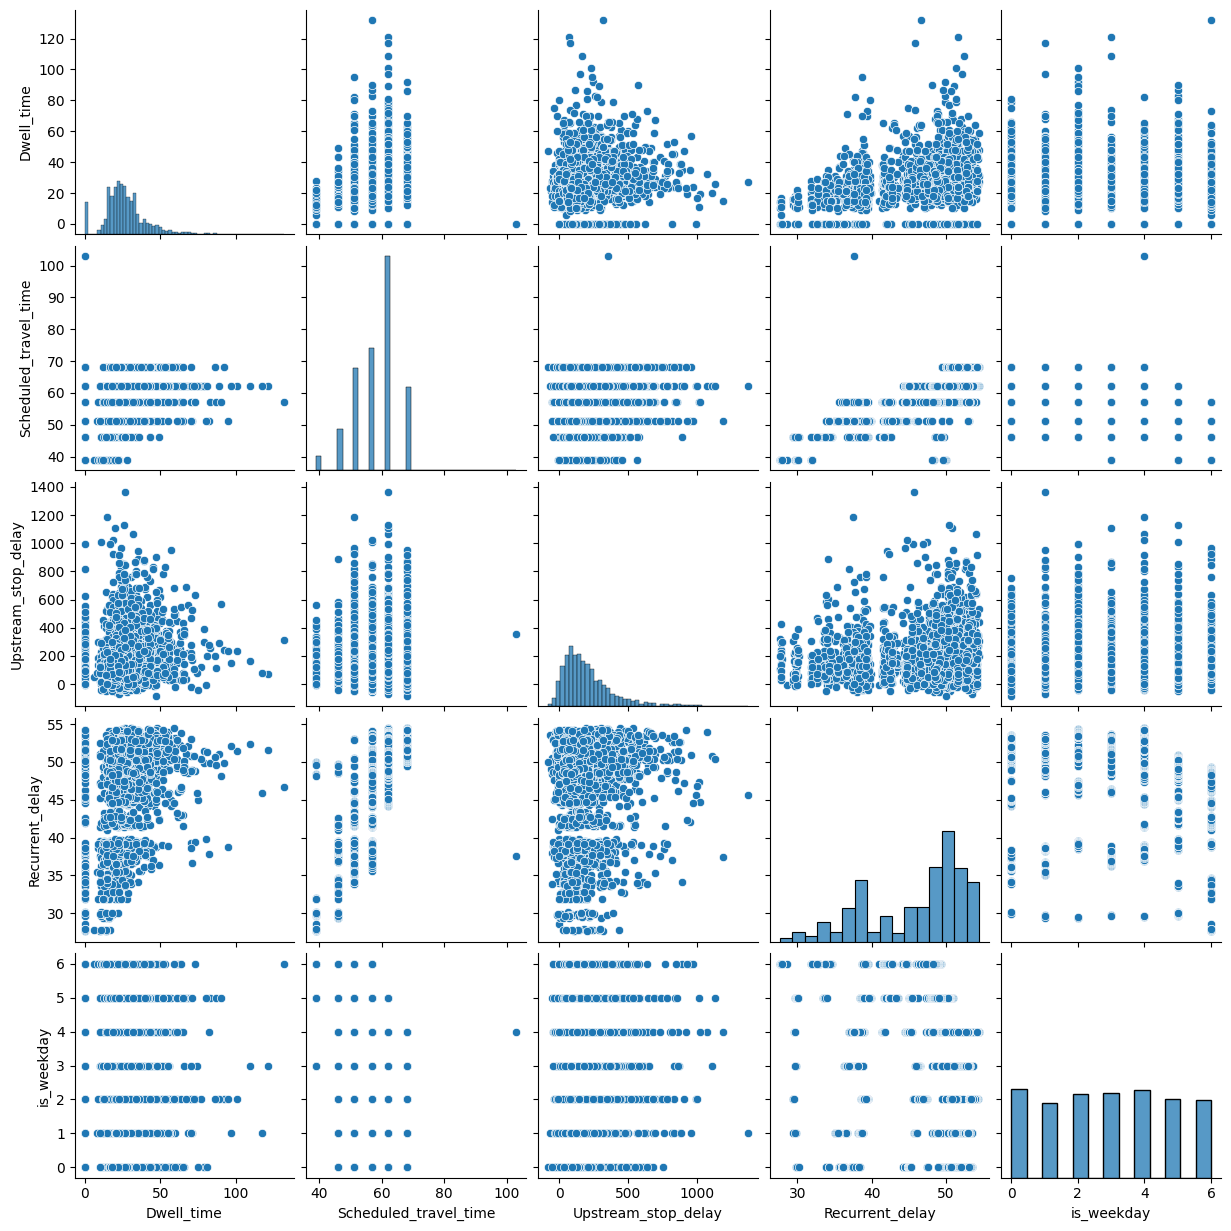

In [95]:
sns.pairplot(x)

Based on the above figures, we can tell there is indeed some correlation between whether that day is a weekday, but not that strong linear relationship. However, considering the model is a decision-tree-based model instead of linear regression. I decided to keep this column to see how it goes.

Step 4: XGBoost with GridSearchCV, set cross-validation=5.

For the params in the following cell, lesson learnt during trying out different couples:

*   Too large n_estimators (number of trees) or max_depth (limits of one single tree's depth), or too low learning rate may make the models too complex or take too long time.
*   For smaller scale dataset, setting cross_validation = 3 fold may be enought. Since this dataset consists of over 2000 data, I set 5 fold anyway.
* The random_state, under most cases, is set 0 or 42 (can also be any other integer, number unsensitive apart from zero). Setting it to be zero means every time I run the code, the data will not be split randomly, which is what I want to see as a test and verification.
* The subsample, is one static trick for preventing overfitting, but must be set <= 1.0. I didn't really get this parameter's physical feature, and wrong set a value > 1, leading to failure in fitting.
*And last but not least, at the very beginning I had wrong mistaken the regressor as classifier. These two modes clarify different situation, requiring different input and parameter settings. I made this mistake out of my careless copying and pasting. Particularly, classifier requires sequent input, starting from 0, and specifically is for classification tasks, during which it usually requires encoding and labelling, and is not this exercise's problem. Input here is continous, targetting at giving a predictive formular.

In [98]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
params = {
    'n_estimators': [130, 150, 180],
    'max_depth': [1, 3, 5],
    'learning_rate': [0.05, 0.08, 0.1],
    'subsample': [0.8, 0.9, 1.0]
    }

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=params, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}


In [99]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
best_regressor = grid_search.best_estimator_
best_regressor.fit(x_train, y_train)
# Make predictions
y_pred = best_regressor.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 11.5491472253012
Mean Squared Error: 274.86590117460463
R-squared: 0.9913540429674419
Root Mean Squared Error: 16.579080227039274


And then i dropped the data that i had added, here is what happened. I have tried out several combinations and what's shown is the best that I have got.

In [100]:
x_dropped = df.drop(['is_weekday'], axis=1)

In [108]:
x_train, x_test, y_train, y_test = train_test_split(x_dropped, y, test_size=0.2, random_state=0)
params = {
    'n_estimators': [120, 130, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 1.0]
    }

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=params, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}


In [109]:
best_regressor = grid_search.best_estimator_
best_regressor.fit(x_train, y_train)
# Make predictions
y_pred = best_regressor.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 1.8988187433382786
Mean Squared Error: 31.75531082331668
R-squared: 0.9990011309087062
Root Mean Squared Error: 5.635185074451121


**Conclusion:**

1.   **It may be not the more data the better.** I added a new column of data (corr. =0.04) based on the date information, but it appears to be less useful before added: under similar algorithm structure, the latter got a 0.999 score, while the former got 0.991. However, it remains uncertain that the low corr. value led to it, that XGBoost itself is not a linear structured algorithm. To verify that, one may try to apply this added column with the linear regression algorithm.
2.   **My best parameters (without my added data):**
  *    Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}
  *   Mean Absolute Error: 1.8988187433382786
  *Mean Squared Error: 31.75531082331668
  *R-squared: 0.9990011309087062
  *Root Mean Squared Error: 5.635185074451121



**Outlook:**


1.   **User view:** predict the transport decision (not going/scooter/metro/bus) based on outer data (such as weather, holiday, public event, location of the neighborhood, etc.). Further, calculate the flow density (time-sensitive), for the companies as reference of deciding the dispatching of shared bycicles/scooters, or the schedule of metro/bus system.

2.  **B2B view:**
  *   **Logistic chain risk management**. Based on outer data (such as public/political event, seasonal data, economic features), to predict potential threatens to the suppliers.
  * **Logistic chain optimization**. Based on the previous flow density, calculate the occupancy in public transport systems and allocate the extra power during non-rush hour to supplement the logistic chain. (Context:the electricity generated will be wasted or partly wasted, if it is not put into use, that in the city the cost of storing electricity is higher than throwing it away.)
  *   **Transportation risk mitigation**. Based on outer data (seasonal data, history data, current system status, etc.), to predict and decide when, and under what scale, to arrange the maintenance, so that to minimize the process's effect on the community.
3. **Planning and policy maker view:**
  * Study how the decision in location of stations and stops affect the **price of real estates** in the neighborhoods.
  * Solutions and optimizations for the **charging / battery-swapping system**, particularly for BEV/NEVs.



**Reference:**

1.   XGBoost python API https://xgboost.readthedocs.io/en/stable/python/python_api.html
2.   https://medium.com/@bravinwasike18/dive-into-xgboost-and-scikit-learnmachine-learning-with-xgboost-and-scikit-learn-17e2cf54f3a3
3.   https://scikit-learn.org/stable/modules/ensemble.html#xgboost
4.   course slide
5.   https://blog.csdn.net/qq_44214428/article/details/140416452
6.   ChatGPT (used prompt):
  *   How is the machine learning model validated usually? is there different rule for different algorithm in terms of choosing validation methods?
  *   Why when tuning hyperparameters one should use cross-validation? how would that work for avoiding overfitting
  *   How to do xgboost algorithm with sklearn in python?
  *   I have over 2000 data, which parameters do you recommend?
  *   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) here what is the use of random_state? why set it zero?
  *   I want to adjust my parameters at the very beginning. but once i changed the number it reports some of the fits failed. what is happening? what should be the principle of adjust the parameters?
  *   What is subsample for? i occasionally set it more than 1.0. And i think this could be part of the reasons of failure



